# Atividade 6

Nesta atividade iremos realizar alguns testes com o classificar Naive Bayes na nossa base de dados, adaptando-o de acordo com as características da nossa base.


## 0. Preparação do ambiente.
Para os trabalhos desta atividade utilizaremos a base de dados previamente carregada no Github, [neste link](https://github.com/danielbdias/pattern-recognition-studies.git), em conjunto com alguns scripts auxiliares

In [1]:
# prepara a máquina local do google colab para receber a base (quando necessário)
# e baixa os scripts auxiliares para a montagem do notebook
#!rm -rf ./*

#!git clone https://github.com/danielbdias/pattern-recognition-studies.git
#!mv ./pattern-recognition-studies/* ./
#!rm -rf ./pattern-recognition-studies
#!rm -rf ./sample_data

#!pip install -r requirements.txt

In [24]:
# imports de libs necessárias para as análises
from scripts.database import load_datapoints_with_targets
from scripts.preprocessing import centralize_observations, principal_component_analysis
from scripts.classification import run_classifier_with_stratified_k_fold
from scripts.graphics import plot_metric

import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, MultinomialNB

## 1. Base de dados

Para o nosso trabalho, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face, seguindo a ordem abaixo:

| Coordenadas (x,y,z) | Região da Face | Coordenadas (x,y,z) | Região da Face |
| --- | --- | --- | --- |
| 0 - 7 (x,y,z) | olho esquerdo | 68 - 86 (x,y,z) | contorno da face |
| 8 - 15 (x,y,z) | olho direito | 87 (x,y,z) | iris esquerda |
| 16 - 25 (x,y,z) | sobrancelha esquerda | 88 (x,y,z) | iris direita |
| 26 - 35 (x,y,z) | sobrancelha direita | 89 (x,y,z) | ponta do nariz |
| 36 - 47 (x,y,z) | nariz | 90 - 94 (x,y,z) | linha acima da sobrancelha esquerda |
| 48 - 67 (x,y,z) | boca | 95 - 99 (x,y,z) | linha acima da sobrancelha direita |

Não há missing values nesses pontos e eles não por um processo de normalização. A classificação de instância é binária onde ela pode ser "Com Expressão" (`"Expression"`, onde os pontos representam a expressão facial) ou "Sem Expressão" (`"Not Expression"`, os pontos não representam uma expressão).

Normalizamos a base buscando centralizar cada frame (observação) em relação a um ponto em comum no frame.
Escolhemos o ponto 89 (`nose tip`) como referência e aplicamos o processo nas seguintes etapas:

1.   Encontramos os valores médios para o ponto 89 nos valores de `x` e `y` (ignoramos o valor de `z` por ele usar uma medida em milimetros ao invés de em pixels, [referência](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions#));
2.   Calculamos os deltas do ponto 89 de cada observação em relação aos valores médios encontrados;
3.   Subtraimos esse delta de todos os pontos de cada observação.

Nesta atividade utilizaremos somente as observações da expressão facial `negativa` em sua forma pré-processada (com os pontos centralizados) de quatro formas diferentes:

- Base com todas as características
- Base transformada pela técnica PCA (resultante da Atividade 03)
- Base com as características encontradas pelo Relief-F (resultante da Atividade 04)
- Base com as características encontradas pelo Algoritmo Genético (resultante da Atividade 04)


### 1.1 Base total (todas as características)

A base de dados com todas as características contém 300 dimensões, estruturadas da seguinte forma:

In [3]:
category = 'negative'
raw_data = load_datapoints_with_targets(category)

dataset = centralize_observations(raw_data)
dataset.describe()

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,97x,97y,97z,98x,98y,98z,99x,99y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,...,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744,0.458241
std,1.625597,2.741896,439.370887,1.766325,2.647455,361.558210,1.909747,2.545192,266.930040,2.068360,...,3.905090,5.389459,89.417381,3.914957,6.521451,351.531081,3.385256,7.330508,555.178027,0.498345
min,303.950854,209.797120,0.000000,300.704854,207.540120,0.000000,296.182854,206.904120,0.000000,291.035854,...,324.399854,191.588120,0.000000,329.433854,190.305120,0.000000,333.625854,190.429120,0.000000,0.000000
25%,308.392854,217.153620,1216.000000,305.627854,215.371120,1221.000000,302.096854,214.948620,1225.000000,298.725104,...,332.981354,200.486870,1265.000000,338.390354,201.331120,1275.000000,342.261354,203.145120,1208.000000,0.000000
50%,309.606354,219.179620,1238.000000,306.972854,217.450620,1243.000000,303.588354,217.093620,1256.000000,300.290354,...,335.892854,206.155620,1284.000000,341.439354,208.103120,1294.000000,345.075854,210.954620,1294.000000,0.000000
75%,310.441854,221.674620,1261.000000,307.857104,219.733870,1270.000000,304.494854,219.018620,1280.000000,301.115854,...,340.044854,210.090870,1294.000000,345.416854,213.098120,1299.000000,348.082604,216.895370,1309.000000,1.000000
max,314.504854,224.502120,1299.000000,312.710854,222.920120,1304.000000,310.230854,222.413120,1314.000000,307.853854,...,348.181854,214.912120,1329.000000,356.601854,219.077120,1542.000000,360.888854,223.073120,1563.000000,1.000000


### 1.2 Base com PCA

A base transformada pelo PCA, considerando apenas os componentes que representam até 80% da variabilidade dos dados, está estruturada da seguinte forma:

In [4]:
features = list(dataset.columns)

pca_results = principal_component_analysis(features, dataset.values)
number_of_chosen_components = len(pca_results.principal_components_under_threshold)
dataset_pca = pd.DataFrame(data=pca_results.X_transformed[:, 0:number_of_chosen_components], columns=pca_results.principal_components_under_threshold)
dataset_pca.insert(number_of_chosen_components, 'target', dataset["target"].values)

dataset_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,target
count,2706.000000,2.706000e+03,2706.000000,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2706.000000
mean,0.000000,-9.679766e-14,0.000000,2.688824e-15,6.453177e-14,-1.075530e-13,-4.571001e-14,1.814956e-14,-8.100082e-14,6.722060e-14,1.613294e-14,1.344412e-14,-5.175986e-14,5.444869e-14,0.458241
std,1529.487923,8.288783e+02,754.072116,6.260129e+02,5.462340e+02,5.340938e+02,4.957597e+02,4.435333e+02,4.423319e+02,4.176105e+02,4.015236e+02,3.878080e+02,3.717674e+02,3.621114e+02,0.498345
min,-2494.036515,-1.817949e+03,-1412.855471,-1.434314e+03,-1.577976e+03,-1.700658e+03,-1.627370e+03,-1.685620e+03,-1.570395e+03,-1.468439e+03,-1.255571e+03,-1.326306e+03,-1.290745e+03,-1.335360e+03,0.000000
25%,-1444.534931,-4.992440e+02,-583.204813,-3.655466e+02,-2.304158e+02,-1.815366e+02,-2.606310e+02,-1.866340e+02,-2.145056e+02,-2.447499e+02,-2.098125e+02,-2.325568e+02,-1.346116e+02,-1.685787e+02,0.000000
50%,357.944939,-4.997479e+01,-42.891897,-1.593658e+01,-6.683547e+00,-1.247349e+01,4.315854e+01,-3.389786e+00,-1.253438e+01,-8.601830e+00,-3.332489e+01,-3.781624e+00,-1.065275e+01,2.084432e+01,0.000000
75%,1319.487879,4.042879e+02,602.397126,3.635263e+02,2.743019e+02,1.803365e+02,2.353098e+02,1.880283e+02,1.721725e+02,2.301877e+02,1.991701e+02,2.275928e+02,1.171180e+02,1.320544e+02,1.000000
max,3017.776144,3.035289e+03,2526.584373,1.814297e+03,1.674262e+03,1.884368e+03,2.005806e+03,1.862771e+03,1.639981e+03,1.543912e+03,1.848362e+03,1.512133e+03,1.503722e+03,1.508445e+03,1.000000


### 1.3 Base com características selecionadas pelo Relief-F

A base com características selecionadas pelo Relief-F considerou as seguintes características:

In [5]:
features_chosen_by_relief = ['41x', '40x', '86x', '42x', '39x', '85x', '44x', '53y', '84x', '68x', '60x', '69x', '15x', '63y', '83x', '70x', '14x', 'target']
dataset_with_relief = dataset[features_chosen_by_relief]
dataset_with_relief.describe()

,41x,40x,86x,42x,39x,85x,44x,53y,84x,68x,60x,69x,15x,63y,83x,70x,14x,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,315.351416,309.820054,349.447013,319.569119,308.938044,349.895513,326.612842,242.286661,349.721362,289.396139,309.200498,289.235498,329.038068,243.888143,348.805798,289.878882,332.324666,0.458241
std,0.492467,0.543975,3.408376,0.574203,0.611865,3.360874,0.480513,1.163002,3.364616,4.203998,1.904017,4.026562,1.264786,1.345394,3.425465,4.065845,1.345895,0.498345
min,313.976854,307.048854,335.942854,317.704854,305.724854,336.153854,325.002854,239.638120,336.030854,270.164854,303.034854,271.046854,323.388854,240.959120,335.005854,272.561854,326.322854,0.000000
25%,315.099854,309.461104,347.459104,319.268854,308.556854,347.919104,326.376854,241.487370,347.467104,287.664604,308.210854,287.761104,328.031104,242.965370,346.491854,288.168104,331.285604,0.000000
50%,315.339854,309.801854,348.869854,319.511854,308.962354,349.444854,326.611854,242.042620,349.403854,289.111354,309.081854,289.020854,329.034354,243.672120,348.531354,289.636854,332.358854,0.000000
75%,315.680604,310.104604,351.472854,319.917854,309.283604,351.934604,326.923854,242.863870,351.836604,291.092854,310.050854,290.785604,329.924604,244.833370,351.170604,291.877104,333.259104,1.000000
max,317.691854,311.745854,360.176854,321.897854,310.900854,360.316854,329.570854,248.535120,359.380854,304.734854,314.551854,303.302854,334.273854,250.784120,357.605854,303.659854,339.373854,1.000000


### 1.4 Base com características selecionadas pelo Algoritmo Genético

A base com características selecionadas pelo algoritmo genético considerou as seguintes características:

In [6]:
features_chosen_by_genetic_algorithm = ['1x', '1y', '2x', '2y', '2z', '3x', '4z', '5y', '6z', '7z', '8x', '8y', '8z', '9x', '9z', '11x', '11y', '11z', '12x', '12z', '13y', '14x', '14y', '15y', '16y', '17y', '18x', '18y', '18z', '19x', '19z', '20x', '20y', '21x', '21z', '22z', '23y', '23z', '24x', '24y', '24z', '25x', '25z', '27y', '28x', '28y', '28z', '31y', '32z', '33x', '33y', '33z', '34y', '35x', '35z', '36x', '37x', '37y', '37z', '38x', '39y', '39z', '40z', '41y', '41z', '42x', '42y', '42z', '43x', '43y', '43z', '44x', '44y', '45z', '46y', '46z', '47z', '48y', '49x', '49y', '50x', '50y', '52z', '53x', '53y', '54x', '54z', '55y', '56x', '56y', '56z', '57x', '57y', '57z', '58x', '58y', '58z', '59x', '60z', '62x', '62y', '62z', '63y', '63z', '66z', '67y', '67z', '68x', '69x', '69y', '70z', '71y', '71z', '72y', '73y', '74y', '74z', '75y', '76x', '76y', '78z', '79z', '80y', '80z', '81y', '81z', '82x', '82y', '83x', '83z', '84x', '84y', '84z', '85y', '85z', '86y', '87z', '88x', '89y', '90x', '90y', '91z', '92y', '92z', '93y', '93z', '94x', '95x', '95z', '96y', '96z', '97x', '97y', '97z', '98y', '99z', 'target']
dataset_with_genetic_algorithm = dataset[features_chosen_by_genetic_algorithm]
dataset_with_genetic_algorithm.describe()

,1x,1y,2x,2y,2z,3x,4z,5y,6z,7z,...,95x,95z,96y,96z,97x,97y,97z,98y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,306.747875,217.450552,303.378426,216.894622,1193.764597,300.074385,1230.535107,220.322486,1038.365484,1009.759793,...,323.691057,1226.466741,205.524790,1264.941981,336.213900,205.329225,1272.370658,207.474289,986.881744,0.458241
std,1.766325,2.647455,1.909747,2.545192,266.930040,2.068360,189.524172,2.627748,467.862472,486.391245,...,2.336497,214.587202,4.355729,85.920339,3.905090,5.389459,89.417381,6.521451,555.178027,0.498345
min,300.704854,207.540120,296.182854,206.904120,0.000000,291.035854,0.000000,211.018120,0.000000,0.000000,...,316.851854,0.000000,193.750120,0.000000,324.399854,191.588120,0.000000,190.305120,0.000000,0.000000
25%,305.627854,215.371120,302.096854,214.948620,1225.000000,298.725104,1234.000000,218.377620,1221.000000,1212.000000,...,321.777604,1243.000000,201.720370,1252.000000,332.981354,200.486870,1265.000000,201.331120,1208.000000,0.000000
50%,306.972854,217.450620,303.588354,217.093620,1256.000000,300.290354,1261.000000,220.787120,1243.000000,1234.000000,...,323.702354,1270.000000,206.275120,1275.000000,335.892854,206.155620,1284.000000,208.103120,1294.000000,0.000000
75%,307.857104,219.733870,304.494854,219.018620,1280.000000,301.115854,1280.000000,222.496870,1270.000000,1261.000000,...,325.720354,1280.000000,209.265870,1289.000000,340.044854,210.090870,1294.000000,213.098120,1309.000000,1.000000
max,312.710854,222.920120,310.230854,222.413120,1314.000000,307.853854,1319.000000,225.919120,1314.000000,1309.000000,...,330.071854,1319.000000,213.009120,1319.000000,348.181854,214.912120,1329.000000,219.077120,1563.000000,1.000000


## 2. Análise de variáveis

Realizamos testes de Kolmogorov-Smirnov para identificar se as características da nossa base de dados possuem uma distribuição normal.

In [7]:
from scipy import stats

def check_normality(dataset, feature):
    alpha = 0.05
#    stat, p = stats.shapiro(dataset[feature])
    stat, p = stats.kstest(dataset[feature], 'norm')
    return (p > alpha) # se true, rejeita a hipótese nula (i.e. a amostra não é semelhante a uma normal)

# Dataset attributes
for feature in features[0:-1]:
    if check_normality(dataset, feature):
        print(f'Feature {feature} looks Gaussian')

# PCA
for principal_component in pca_results.principal_components_under_threshold:
    if check_normality(dataset_pca, principal_component):
        print(f'Principal Component {principal_component} looks Gaussian')
    

## 3. Treinamento e avaliação da acurácia

Visto que o nosso dataset contém variáveis contínuas para as dimensões que representam `x` e `y`, optamos por usar a implementação `GaussianNB` do `scikit-learn` como algoritmo indutor dos classificadores (que assume que a verossimilhança entre as variáveis é gaussiana).

Iremos variar os parâmetros do Naive-Bayes Gaussiano nos valores `[10e-10, 10e-5, 1]` e utilizaremos o `10-fold cross validation` (implementado na atividade 5) para estimar o erro de classificação.

In [8]:
classifier_builder = lambda parameter: GaussianNB(var_smoothing = parameter)
parameters = [10e-10, 10e-5, 1]
K = 10

### 3.1 Dataset inteiro

Nesta etapa, iremos avaliar o GaussianNB com a utilização de todas as características do nosso dataset.


In [9]:
dataset_results = run_classifier_with_stratified_k_fold(parameters, classifier_builder, dataset, K)
dataset_results

,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,1.000000e-09,0.709334,"[0.577858, 0.84081]",0.736290,"[0.628463, 0.844117]",0.697034,"[0.556206, 0.837862]"
1,1.000000e-04,0.625640,"[0.571114, 0.680167]",0.362903,"[0.319561, 0.406245]",0.708385,"[0.599955, 0.816814]"
2,1.000000e+00,0.623522,"[0.557983, 0.689061]",0.592742,"[0.363634, 0.82185]",0.753736,"[0.590445, 0.917028]"


### 3.2 Dataset após PCA
Nesta etapa, iremos avaliar o GaussianNB com a utilização de todas as características transformadas pelo PCA.


In [10]:
dataset_pca_results = run_classifier_with_stratified_k_fold(parameters, classifier_builder, dataset_pca, K)
dataset_pca_results

,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,1.000000e-09,0.643049,"[0.602787, 0.683311]",0.535484,"[0.472217, 0.59875]",0.642213,"[0.575111, 0.709316]"
1,1.000000e-04,0.643419,"[0.60268, 0.684159]",0.535484,"[0.472217, 0.59875]",0.643073,"[0.574928, 0.711219]"
2,1.000000e+00,0.635277,"[0.619313, 0.651241]",0.300000,"[0.227699, 0.372301]",0.841983,"[0.7132, 0.970767]"


### 3.3 Dataset após Relief-F

Nesta etapa, iremos avaliar o GaussianNB com a utilização de todas as características selecionadas pelo Relief-F.

In [11]:
dataset_with_relief_results = run_classifier_with_stratified_k_fold(parameters, classifier_builder, dataset_with_relief, K)
dataset_with_relief_results

,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,1.000000e-09,0.698681,"[0.579746, 0.817616]",0.667742,"[0.569432, 0.766052]",0.761592,"[0.591399, 0.931784]"
1,1.000000e-04,0.699791,"[0.580934, 0.818648]",0.667742,"[0.569432, 0.766052]",0.763227,"[0.593064, 0.93339]"
2,1.000000e+00,0.638281,"[0.590793, 0.685768]",0.251613,"[0.12438, 0.378845]",0.921806,"[0.835788, 1.007823]"


### 3.4 Dataset após Algoritmo Genético

Nesta etapa, iremos avaliar o GaussianNB com a utilização de todas as características selecionadas pelo Algoritmo Genético.


In [12]:
dataset_with_genetic_algorithm_results = run_classifier_with_stratified_k_fold(parameters, classifier_builder, dataset_with_genetic_algorithm, K)
dataset_with_genetic_algorithm_results

,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,1.000000e-09,0.711259,"[0.585438, 0.83708]",0.681452,"[0.581188, 0.781715]",0.724727,"[0.57591, 0.873543]"
1,1.000000e-04,0.576930,"[0.519944, 0.633916]",0.204032,"[0.077755, 0.330309]",0.627153,"[0.369263, 0.885043]"
2,1.000000e+00,0.628335,"[0.541902, 0.714769]",0.658871,"[0.443528, 0.874214]",0.722890,"[0.567276, 0.878505]"


## 4. Resultados

Os resultados finais para os classificadores pode ser visto na tabela abaixo:

Para estes resultados, assumimos um intervalo de confiança de 95%.

In [13]:
def find_param_with_max_accuracy(results):
    sorted_results = results.sort_values(by=['Mean Accuracy'], ascending=False)
    return sorted_results.head(1)

final_results = pd.concat([
    find_param_with_max_accuracy(dataset_results),
    find_param_with_max_accuracy(dataset_pca_results),
    find_param_with_max_accuracy(dataset_with_relief_results),
    find_param_with_max_accuracy(dataset_with_genetic_algorithm_results)
])
final_results.insert(0, 'Datasets', [ 'All Features', 'PCA', 'Relief-F', 'Genetic Algorithm' ])
final_results

,Datasets,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,All Features,1.000000e-09,0.709334,"[0.577858, 0.84081]",0.736290,"[0.628463, 0.844117]",0.697034,"[0.556206, 0.837862]"
1,PCA,1.000000e-04,0.643419,"[0.60268, 0.684159]",0.535484,"[0.472217, 0.59875]",0.643073,"[0.574928, 0.711219]"
1,Relief-F,1.000000e-04,0.699791,"[0.580934, 0.818648]",0.667742,"[0.569432, 0.766052]",0.763227,"[0.593064, 0.93339]"
0,Genetic Algorithm,1.000000e-09,0.711259,"[0.585438, 0.83708]",0.681452,"[0.581188, 0.781715]",0.724727,"[0.57591, 0.873543]"


Os gráficos das métricas para cada base de dados pode ser visto abaixo.

Uma característica interessante desses dados é que apesar de a base transformada pelo PCA ter tido o pior desempenho, ela teve o menor intervalo de confiança. Isto pode se dever ao fato de os PCs serem independentes, algo que o Naive-Bayes assume na topologia da Rede Bayesiana dele.

In [14]:
def plot_classifier_metric(metric_name, final_results):
    classifier = 'Naive-Bayes'
    means = final_results[f'Mean {metric_name}'].values
    confidence_intervals = final_results[f'{metric_name} Confidence Interval'].values

    dataset_labels = final_results['Datasets'].values
    classifier_metrics = [
        (means, confidence_intervals, classifier)
    ]

    plot_metric(metric_name, dataset_labels, classifier_metrics)

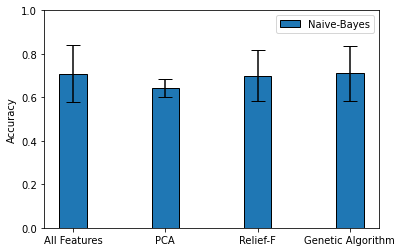

In [15]:
plot_classifier_metric('Accuracy', final_results)

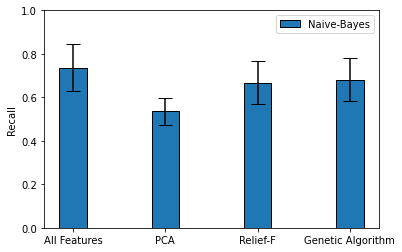

In [16]:
plot_classifier_metric('Recall', final_results)

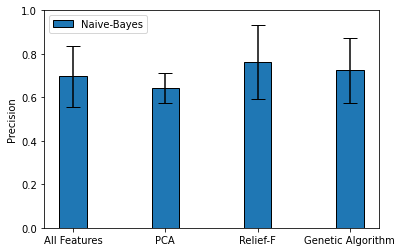

In [17]:
plot_classifier_metric('Precision', final_results)

# TODO

- pensar em calibração